# Мультикласова класифікація

Працюватиму з наступним набором даних:
https://archive.ics.uci.edu/ml/datasets/car+evaluation

Буду передбачувати клас автомобілів відповідно до його характеристик. Клас може бути unacceptable, acceptable, good, very good.

Завантажуватиму набір даних з збереженого car+evaluation.csv

0. Імпорт бібліотек.

In [ ]:
import warnings

warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay


1.1. Завантажую набір даних у змінну df.

In [ ]:
df = pd.read_csv('car+evaluation.csv')
display(df.head())
df.info()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   vhigh    1727 non-null   object
 1   vhigh.1  1727 non-null   object
 2   2        1727 non-null   object
 3   2.1      1727 non-null   object
 4   small    1727 non-null   object
 5   low      1727 non-null   object
 6   unacc    1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


1.2. Набір даних не має імен стовпців. Дам наступні імена стовпцям:
`['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']`

In [ ]:
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


2. Виведу кількість зустрічей кожної з незалежних змінних програмно. 

In [ ]:
for i in df.columns[:-1]:
  a = df[i].value_counts()
  print(a, '\n')


high     432
med      432
low      432
vhigh    431
Name: buying, dtype: int64 

high     432
med      432
low      432
vhigh    431
Name: maint, dtype: int64 

3        432
4        432
5more    432
2        431
Name: doors, dtype: int64 

4       576
more    576
2       575
Name: persons, dtype: int64 

med      576
big      576
small    575
Name: lug_boot, dtype: int64 

med     576
high    576
low     575
Name: safety, dtype: int64 



3. Виведу скільки рядків відповідають кожному із значень цільової змінної. 

In [ ]:
df['class'].value_counts()

unacc    1209
acc       384
good       69
vgood      65
Name: class, dtype: int64




> Ця змінна є ординальна, оскільки дозволяє ранжирувати об’єкти, вказавши, які з них у більшій, а які у меншій мірі мають певну якість. Але вони не можуть сказати, на скільки більше або менше. Тобто, можна сказати, що клас "unacceptable" характеризує найгірший клас машин, а клас "very good" - найкращий.

> Класифікація в цьому випадку буде незбалансована, оскільки, для одного з класів маємо 1209 одиниць, а для іншого - 69. Це говорить про сильну незбалансованість класу.



4. Перевірю чи є відсутні значення у змінних.

In [ ]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

5.1. Запишу у змінну `x` всі незалежні змінні, а у змінну `y` - цільову.


In [ ]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]


5.2. Розділю дані на тренувальну та тестову вибірки. Встановлю random_state рівним 42 та test_size рівним 0.33.

In [ ]:
X_train_df, X_test_df, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.33, random_state=42)


5.3. Виведу форму та перші 5 записів отриманих X_train_df, X_test_df.

In [ ]:
print('TRAIN',X_train_df.shape)
display(X_train_df.head())
print('\n','TEST', X_test_df.shape)
X_test_df.head()

TRAIN (1157, 6)


,buying,maint,doors,persons,lug_boot,safety
83,vhigh,vhigh,5more,2,med,low
48,vhigh,vhigh,3,more,med,med
468,high,vhigh,3,4,small,med
155,vhigh,high,3,more,med,low
1043,med,high,4,more,small,low



 TEST (570, 6)


,buying,maint,doors,persons,lug_boot,safety
599,high,high,4,2,big,low
932,med,vhigh,4,4,big,low
628,high,high,5more,2,big,high
1497,low,high,5more,4,med,med
1262,med,low,4,more,med,low


6.1. Виведу типи даних усіх змінних у X_train.

In [ ]:
X_train_df.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

6.2. Застосую енкодер на трен. та тест. даних з використанням бібліотеки  sklearn.preprocessing.


In [ ]:

buying_categories = ['low', 'med', 'high', 'vhigh']
maint_categories = ['low', 'med', 'high', 'vhigh']
doors_categories = ['2', '3', '4', '5more']
persons_categories = ['2', '3', '4','more']
lug_but_categories = ['small','med', 'big']
safety_categories = ['low', 'med', 'high']
cl_names = ['unacc', 'acc', 'good','vgood']

encoder = OrdinalEncoder(categories=[buying_categories, maint_categories,doors_categories,
                                     persons_categories,lug_but_categories,safety_categories])
encoder.fit(X_train_df)
X_train = encoder.transform(X_train_df)
X_test = encoder.transform(X_test_df)

encoder_turget = OrdinalEncoder(categories=[cl_names])
encoder_turget.fit(y_train_0.values.reshape(-1,1))
y_train = encoder_turget.transform(y_train_0.values.reshape(-1,1))
y_test= encoder_turget.transform(y_test_0.values.reshape(-1,1))


6.3. Виведу перші 5 записів X_train, X_test.

In [ ]:
print('encoder_train:','\n', X_train[:5], '\n')
print('encoder_test:', '\n', X_test[:5])


encoder_train: 
 [[3. 3. 3. 0. 1. 0.]
 [3. 3. 1. 3. 1. 1.]
 [2. 3. 1. 2. 0. 1.]
 [3. 2. 1. 3. 1. 0.]
 [1. 2. 2. 3. 0. 0.]] 

encoder_test: 
 [[2. 2. 2. 0. 2. 0.]
 [1. 3. 2. 2. 2. 0.]
 [2. 2. 3. 0. 2. 2.]
 [0. 2. 3. 2. 1. 1.]
 [1. 0. 2. 3. 1. 0.]]


6.4. Виведу отримані категорії енкодера.

In [ ]:
print(encoder.categories_)
print(encoder_turget.categories_)

[array(['low', 'med', 'high', 'vhigh'], dtype=object), array(['low', 'med', 'high', 'vhigh'], dtype=object), array(['2', '3', '4', '5more'], dtype=object), array(['2', '3', '4', 'more'], dtype=object), array(['small', 'med', 'big'], dtype=object), array(['low', 'med', 'high'], dtype=object)]
[array(['unacc', 'acc', 'good', 'vgood'], dtype=object)]


7.1. Проведу навчання логістичної регресії на отриманих даних.  Встановлю random_state=42, а  інші параметрами залишу за замовчуванням.

In [ ]:
log_regr_model = LogisticRegression(random_state=42)
log_regr_model.fit(X_train, y_train)


LogisticRegression(random_state=42)

7.2. Зроблю прогнози за допомогою отриманої моделі і методу predict. 

In [ ]:
y_pred_test = log_regr_model.predict(X_test)
y_pred_train = log_regr_model.predict(X_train)

7.3. Виведу метрики якості за допомогою classification_report.

In [ ]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       810
         1.0       0.70      0.65      0.67       257
         2.0       0.64      0.49      0.56        51
         3.0       0.85      0.74      0.79        39

    accuracy                           0.85      1157
   macro avg       0.77      0.71      0.74      1157
weighted avg       0.84      0.85      0.84      1157

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       399
         1.0       0.71      0.68      0.69       127
         2.0       0.55      0.33      0.41        18
         3.0       0.84      0.81      0.82        26

    accuracy                           0.86       570
   macro avg       0.75      0.69      0.71       570
weighted avg       0.85      0.86      0.86       570



Для порівняння різних моделей та вибору найкращої з них я використовуватиму метрику f1-score. Оскільки, ця метрика допомагає збалансувати два показники: precision і recall. Адже  важливо не лише дізнатися частку визначених правильно класів серед наших передбачень, але й частку правильно визначених значень з усієї множини елементів, які належать до даного класу.

8.1. Використовуючи ті самі дані проведу навчання моделі дерева рішень з допомогою sklearn.tree (встановлю параметр глибини 4). Обчислю прогнози і порахую метрику якості на test даних. 

In [ ]:
decis_tree_model = tree.DecisionTreeClassifier(max_depth=4)
decis_tree_model.fit(X_train, y_train)
decis_y_pred = decis_tree_model.predict(X_test)

print(classification_report(y_test, decis_y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       399
         1.0       0.75      0.72      0.74       127
         2.0       0.31      1.00      0.47        18
         3.0       0.00      0.00      0.00        26

    accuracy                           0.85       570
   macro avg       0.51      0.67      0.54       570
weighted avg       0.85      0.85      0.84       570



8.2. Виведу параметри моделі Decision Tree.

In [ ]:
decis_tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

8.3. Візуалізація отриманого дерева рішень.

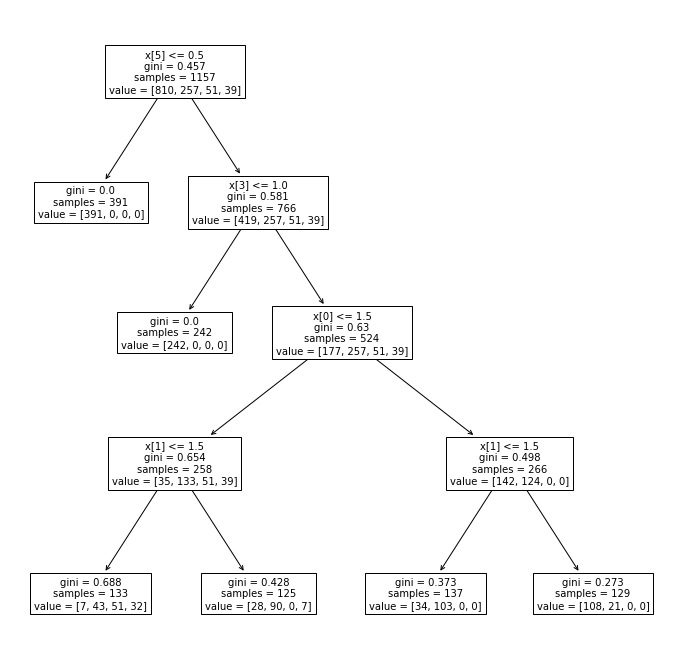

In [ ]:
plt.figure(figsize=(12,12))
tree.plot_tree(decis_tree_model, fontsize=10)
plt.show()

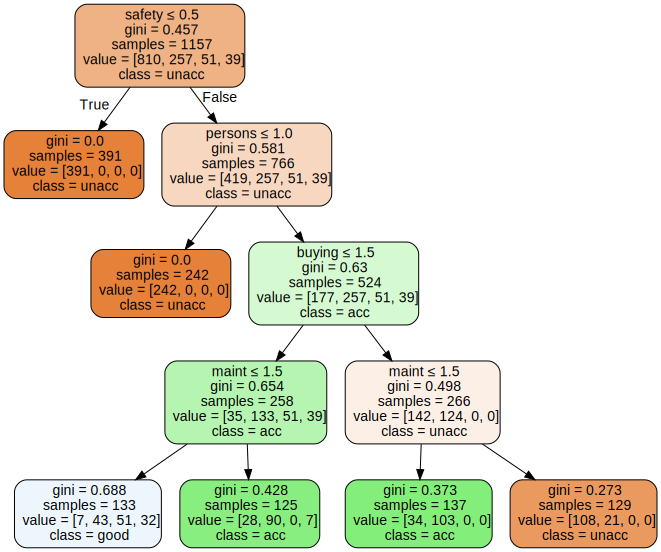

In [ ]:
dot_data = tree.export_graphviz(decis_tree_model, 
                     out_file=None, 
                     feature_names=df.columns[:-1],  
                     class_names=['unacc', 'acc', 'good','vgood'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph

9.1. Здійсню пошук гіперпараметрів для DecisionTree за сіткою за допомогою sklearn.

In [ ]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15), 'min_samples_leaf': np.arange(1, 5)}
clf = GridSearchCV(decis_tree_model, param_grid, cv=5)
clf.fit(X_train, y_train)
display(clf.best_params_)
y_pred_clf = clf.predict(X_test)

{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1}

9.2. Виведу claasification report фінальної моделі пошуку гіперпараметрів.

In [ ]:
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       399
         1.0       0.94      0.93      0.93       127
         2.0       0.74      0.78      0.76        18
         3.0       0.91      0.81      0.86        26

    accuracy                           0.96       570
   macro avg       0.89      0.88      0.88       570
weighted avg       0.96      0.96      0.96       570



9.3. Виведу матрицю помилок для кращої моделі у пошуку гіперпараметрів. 

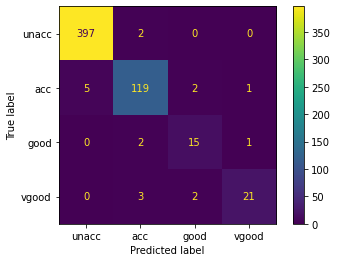

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred_clf)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=cl_names)
cm_display.plot()
plt.show()


При використанні логістичної регресії найгірше визначався клас 'good' (f1-score 0.41 на тесті) та 'acc'(0.69 на тесті). При використанні моделі дерева рішень без підбору гіперпараметрів точність визначення цих двох класів злегка покращується (f1-score 0.47 і 0.74, відповідно), але взагалі не визначає клас 'vgood'. При використанні дерева рішення з підбором оптимальних значень гіперпараметрів найгірше визначається клас 'good' (0.81) і 'vgood'(0.86). Отже, узагальнюючи можна сказати, що при використанні моделі логістичної регресії найгірше визначаються класи 'good' і 'acc', а при використані моделі дерева рішень 'good' і 'vgood'. На мою думку, проблеми визначення класів при використанні моделі дерева рішень може бути пов'язано з малою кількістю записів саме для тих класів.

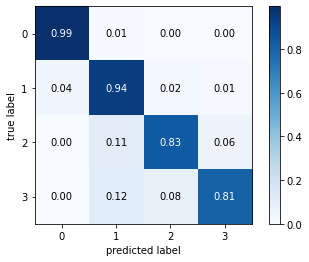

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True )
plt.show()